## Problem Statement - HMMs and Viterbi algorithm for POS tagging

In this assignment, need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

- Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.
- Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?

#### Need to accomplish the following in this assignment:

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math
import re
from collections import Counter

In [2]:
#reading the Treebank tagged universal dataset sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print("Size of NLTK Dataset:",len(nltk_data))

Size of NLTK Dataset: 3914


In [3]:
#lets take a look on few sentences from NLTK datset
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
#split dataset into train & validation sets in the ratio of 95:5 as mentioned.
train, validation = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state=99)
print("Size of train Data:",len(train))
print("Size of validation Data:",len(validation))

Size of train Data: 3718
Size of validation Data: 196


In [5]:
#lets take a look on train data set
print(train[:10])

[[('It', 'PRON'), ('also', 'ADV'), ('empowers', 'VERB'), ('the', 'DET'), ('president', 'NOUN'), ('to', 'PRT'), ('make', 'VERB'), ('recess', 'NOUN'), ('appointments', 'NOUN'), (',', '.'), ('without', 'ADP'), ('Senate', 'NOUN'), ('approval', 'NOUN'), (':', '.'), ('``', '.'), ('The', 'DET'), ('President', 'NOUN'), ('shall', 'VERB'), ('have', 'VERB'), ('Power', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('fill', 'VERB'), ('up', 'PRT'), ('all', 'DET'), ('Vacancies', 'NOUN'), ('that', 'DET'), ('*T*-1', 'X'), ('may', 'VERB'), ('happen', 'VERB'), ('during', 'ADP'), ('the', 'DET'), ('Recess', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Senate', 'NOUN'), (',', '.'), ('by', 'ADP'), ('*-2', 'X'), ('granting', 'VERB'), ('Commissions', 'NOUN'), ('which', 'DET'), ('*T*-40', 'X'), ('shall', 'VERB'), ('expire', 'VERB'), ('at', 'ADP'), ('the', 'DET'), ('End', 'NOUN'), ('of', 'ADP'), ('their', 'PRON'), ('next', 'ADJ'), ('Session', 'NOUN'), ('.', '.'), ("''", '.')], [('Note', 'VERB'), (':', '.'), ('All', 'DET'), (

In [6]:
#lets extract tagged words and take a look into data
train_tagged_words = [tup for s in train for tup in s]
print("Size of tagged words:",len(train_tagged_words))
print(train_tagged_words[:20])

Size of tagged words: 95779
[('It', 'PRON'), ('also', 'ADV'), ('empowers', 'VERB'), ('the', 'DET'), ('president', 'NOUN'), ('to', 'PRT'), ('make', 'VERB'), ('recess', 'NOUN'), ('appointments', 'NOUN'), (',', '.'), ('without', 'ADP'), ('Senate', 'NOUN'), ('approval', 'NOUN'), (':', '.'), ('``', '.'), ('The', 'DET'), ('President', 'NOUN'), ('shall', 'VERB'), ('have', 'VERB'), ('Power', 'NOUN')]


In [7]:
#extract vocabulary and its tag from train tagged words
V = (set(pair[0] for pair in train_tagged_words))
T =   (set(pair[1] for pair in train_tagged_words))
G = ((pair[0] for pair in train_tagged_words))
print("Size of Vocabulary:",len(V))
print("Size of Tags:",len(T))
print("All unique tags:",T)

Size of Vocabulary: 12080
Size of Tags: 12
All unique tags: {'DET', 'PRON', 'ADJ', 'NOUN', 'ADV', '.', 'CONJ', 'X', 'NUM', 'PRT', 'ADP', 'VERB'}


In [8]:
#View the first 10 words in the training set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['It',
 'also',
 'empowers',
 'the',
 'president',
 'to',
 'make',
 'recess',
 'appointments',
 ',']

### Build the vanilla Viterbi based POS tagger

In [9]:
#computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

#### Define Emission Probability Function:

In [10]:
#compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Define Transition Probability Function

In [11]:
#compute tag given tag: tag2 (t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
#convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,DET,PRON,ADJ,NOUN,ADV,.,CONJ,X,NUM,PRT,ADP,VERB
DET,0.005799,0.003382,0.205968,0.638077,0.012563,0.017758,0.000483,0.045059,0.022348,0.000242,0.009302,0.039019
PRON,0.008806,0.008040,0.073507,0.208270,0.034839,0.040199,0.005360,0.092649,0.007274,0.012251,0.022205,0.486600
ADJ,0.004428,0.000656,0.067082,0.700180,0.004756,0.065770,0.016894,0.020502,0.020666,0.010333,0.077087,0.011645
NOUN,0.012951,0.004766,0.012260,0.264152,0.017026,0.240287,0.042637,0.028522,0.009350,0.043946,0.176732,0.147373
ADV,0.068484,0.014628,0.129654,0.031582,0.078790,0.135306,0.006649,0.023936,0.031915,0.013963,0.119348,0.345745
.,0.172163,0.066768,0.044721,0.222710,0.052160,0.093207,0.057985,0.027066,0.081197,0.002330,0.091593,0.088009
CONJ,0.117975,0.059452,0.116582,0.350673,0.053414,0.035300,0.000464,0.008360,0.042267,0.005109,0.053878,0.156526
X,0.055201,0.055680,0.017071,0.062540,0.025367,0.162891,0.010370,0.074665,0.002712,0.182833,0.146299,0.204371
NUM,0.003837,0.001476,0.032763,0.352420,0.002952,0.114817,0.012987,0.212515,0.185950,0.027155,0.035419,0.017710
PRT,0.102034,0.017388,0.085958,0.248688,0.009843,0.043963,0.002297,0.014108,0.057087,0.001640,0.020013,0.396982


In [14]:
tags_df.loc['.', :]

DET     0.172163
PRON    0.066768
ADJ     0.044721
NOUN    0.222710
ADV     0.052160
.       0.093207
CONJ    0.057985
X       0.027066
NUM     0.081197
PRT     0.002330
ADP     0.091593
VERB    0.088009
Name: ., dtype: float32

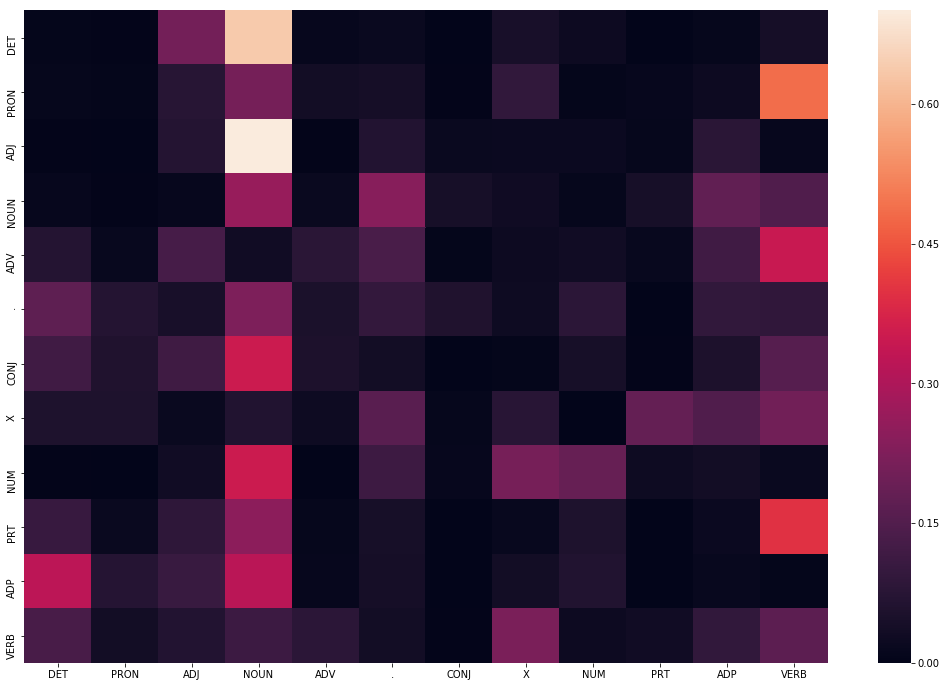

In [16]:
# heatmap of tags matrix - Lets visualize transition probabilities as heat map
# T(i, j) indicates P(tag j given tag i)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

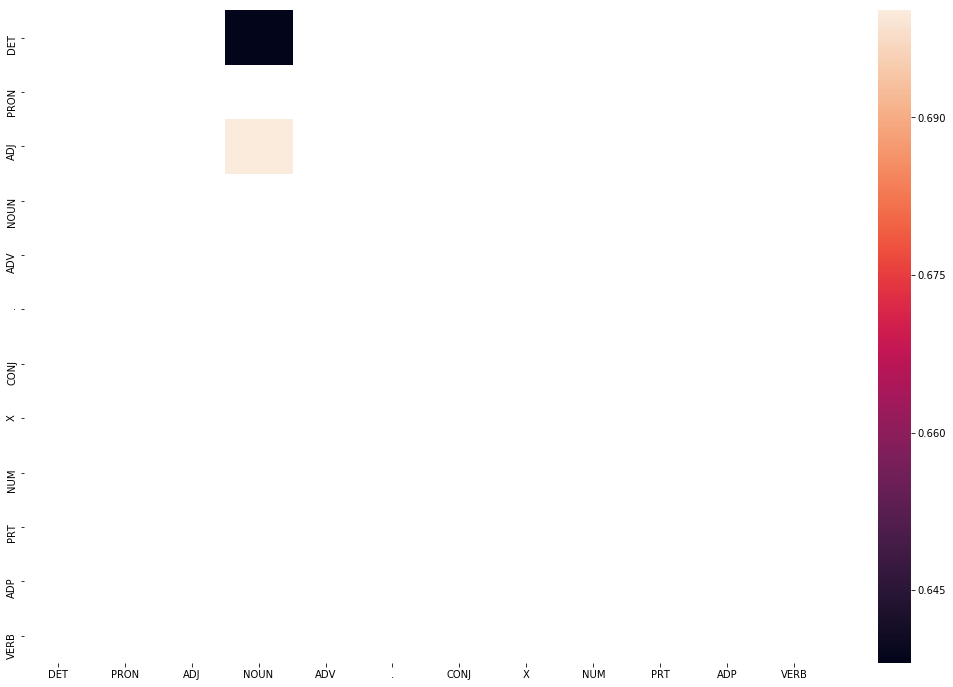

In [17]:
# frequent tags where transition probabilities are greater than 0.5
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

- Above heat map indicates that transition probability of Noun given Adjective and Noun given DET is more than 0.5.

In [18]:
#lets again look into size of trainng tagged words
print("Total size of Train Tagged Words :",len(train_tagged_words))

Total size of Train Tagged Words : 95779


## Vanilla Viterbi Algorithm Implementation

Steps:

- Use the computed probabilities P(w, tag) emission and P(t2, t1) transition to assign tags to each word in the document. 
- Run through each word w and compute state probability P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, 
- and then assign the tag having the max P(tag/w) state probability.
- Store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

- Note: P(tag|start) = P(tag|'.') 

In [19]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
# Running on entire validation dataset is taking close to 30 minutes of time.
# Let's test our vanilla Viterbi algorithm on a validation dataset

# list of tagged words means words along with their tags
val_run_base = [tup for sent in validation for tup in sent]

# list of untagged words means only words and no tags
val_tagged_words = [tup[0] for sent in validation for tup in sent]

In [21]:
# tagging the validation dataset sentences using vanilla viterbi algorithm
start = time.time()
vanilla_tagged_seq = Viterbi(val_tagged_words)
end = time.time()
difference = end-start

In [22]:
#total time taken to train the vanilla viterbi algorithm
print(difference)

1141.4168570041656


In [23]:
#lets compute accuracy with viterbi algoritham
check = [i for i, j in zip(vanilla_tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(vanilla_tagged_seq)
print("Accuracy:",accuracy)

Accuracy: 0.9056565244026955


#### We got more than 90% of accuracy with the vanilla Viterbi algorithm. 
- There are many words which are not tagged correctly with vanilla version of viterbi algorithm.
- Lets proceed further & work towards improving its accuracy.
- Identify ways to tag unknown words.


In [24]:
#lets find the incorrect tagged cases after vanilla viterbi algoritham
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(vanilla_tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('be', 'VERB'), (('less', 'ADJ'), ('less', 'ADV'))],
 [('sink', 'VERB'), (('up', 'ADV'), ('up', 'ADP'))],
 [('for', 'ADP'), (('overnight', 'DET'), ('overnight', 'ADJ'))],
 [('first', 'ADJ'), (('half', 'NOUN'), ('half', 'DET'))],
 [('to', 'PRT'), (('88.32', 'DET'), ('88.32', 'NUM'))],
 [('$', '.'), (('618.1', 'DET'), ('618.1', 'NUM'))],
 [('from', 'ADP'), (('77.6', 'DET'), ('77.6', 'NUM'))],
 [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))],
 [('team', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('Mercury', 'NOUN'), (('Sable', 'DET'), ('Sable', 'NOUN'))],
 [('*-2', 'X'), (('experiencing', 'DET'), ('experiencing', 'VERB'))],
 [('publicly', 'ADV'), (('apologizing', 'DET'), ('apologizing', 'VERB'))],
 [('*', 'X'), (('indulging', 'DET'), ('indulging', 'VERB'))],
 [('.', '.'), (('Municipal', 'NOUN'), ('Municipal', 'ADJ'))],
 [('demand', 'NOUN'), (('th

- We can observe that many words are tagged incorretcly as DET but actually they are not DET.

In [25]:
#Reading the given test sentence dataset
test = pd.read_csv("Test_sentences.txt", sep = "\t", names=["message"])
#Converting the read dataset in to a list of tuples.
test_set = []
for index,row in test.iterrows():
    test_set.append((row['message']))
test_set

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

### Solve the problem of unknown words

In [26]:
#lets do predictions on test file that was provided using vanilla viterbi algorithm
test_list =[]
for l in test_set:
    test_list=test_list+list(Viterbi(word_tokenize(l)))
print(test_list)

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'DET'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

#### Observations:
- After looking into above tags the words which were not present in training set were tagged incorrectly for validation set.
- For example Android, Google, Twitter and there are many other words which are incorrectly tagged as DET.
- There are words like 2011, 2015, 2018 all are incorectly tagged as DET.
- There are words like arriving, invited are tagged incorrectly.
- As we can see there are many other issues as well with vanilla viterbi algoritham. 

In [27]:
#lets find all the words in the test file
test_words=[tokens for l in test_set for tokens in word_tokenize(l)]
print(test_words)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [28]:
#words which are present in test dataset but not in the training dataset
words_not_in_train = list(set(test_words) - set(tokens))
print(words_not_in_train)

['interact', 'tweets', 'smartphones', 'trips', 'Android', '2011', 'OS', 'domineering', 'FIFA', '21st', 'networking', 'Cup', '2013', 'NASA', 'firehose', 'tournament', 'contested', '2015', 'personality', 'arriving', 'invited', 'ICESAT-2', 'messages', 'worldwide', '2018', 'Google', 'online', 'Satellite', 'Twitter']


- We can clearly notice that Android, Twitter, Google are not part of train set that is why they were tagged incorrectly for words present in test dataset.
- Numbers like 2018, 2015 are also tagged incorrectly due to same issue.
- words like invited, contested, arriving tagged incorrectly.
- Lets do some EDA and find some insights to proceed further with tagging unknown words.

In [29]:
#lets look into tags predicted for unknown words
[tup for tup in test_list for word in words_not_in_train if tup[0]==word ]

[('Android', 'DET'),
 ('Google', 'DET'),
 ('Android', 'DET'),
 ('OS', 'DET'),
 ('worldwide', 'DET'),
 ('smartphones', 'DET'),
 ('2011', 'DET'),
 ('2013', 'DET'),
 ('Google', 'DET'),
 ('Twitter', 'DET'),
 ('2015', 'DET'),
 ('Google', 'DET'),
 ('Twitter', 'DET'),
 ('firehose', 'DET'),
 ('Twitter', 'DET'),
 ('online', 'DET'),
 ('networking', 'DET'),
 ('interact', 'DET'),
 ('messages', 'DET'),
 ('tweets', 'DET'),
 ('domineering', 'DET'),
 ('personality', 'DET'),
 ('2018', 'DET'),
 ('FIFA', 'DET'),
 ('Cup', 'DET'),
 ('21st', 'DET'),
 ('FIFA', 'DET'),
 ('Cup', 'DET'),
 ('tournament', 'DET'),
 ('contested', 'DET'),
 ('Cup', 'DET'),
 ('trips', 'DET'),
 ('arriving', 'DET'),
 ('NASA', 'DET'),
 ('invited', 'DET'),
 ('ICESAT-2', 'DET'),
 ('Satellite', 'DET')]

In [30]:
#lets find the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
print(tag_counts)

Counter({'NOUN': 27488, 'VERB': 12890, '.': 11158, 'ADP': 9391, 'DET': 8278, 'X': 6268, 'ADJ': 6097, 'NUM': 3388, 'PRT': 3048, 'ADV': 3008, 'PRON': 2612, 'CONJ': 2153})


In [31]:
#lets find the most common tags present in the training dataset
tag_counts.most_common(5)

[('NOUN', 27488), ('VERB', 12890), ('.', 11158), ('ADP', 9391), ('DET', 8278)]

#### Exploratory Analysis on training dataset to find some insights

In [32]:
#how many words with the tag 'VERB' (verb, past tense) end with 'ed'
past_tense_verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in past_tense_verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(past_tense_verbs))
ed_verbs[:20]

0.20512024825446082


[('diluted', 'VERB'),
 ('adjusted', 'VERB'),
 ('declared', 'VERB'),
 ('fared', 'VERB'),
 ('shipped', 'VERB'),
 ('posted', 'VERB'),
 ('plummeted', 'VERB'),
 ('surrendered', 'VERB'),
 ('increased', 'VERB'),
 ('led', 'VERB'),
 ('opposed', 'VERB'),
 ('construed', 'VERB'),
 ('promised', 'VERB'),
 ('rejected', 'VERB'),
 ('denied', 'VERB'),
 ('priced', 'VERB'),
 ('estimated', 'VERB'),
 ('auctioned', 'VERB'),
 ('voted', 'VERB'),
 ('listed', 'VERB')]

- As we can see close to 20% words are verb which end with "ed". 
- Rule based tagger can be built to tage these words.

In [33]:
#how many words with the tag 'VERB' end with 'ing'
participle_verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in participle_verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(participle_verbs))
ing_verbs[:20]

0.1091543832428239


[('granting', 'VERB'),
 ('earning', 'VERB'),
 ('beginning', 'VERB'),
 ('reaching', 'VERB'),
 ('saying', 'VERB'),
 ('hugging', 'VERB'),
 ('using', 'VERB'),
 ('exerting', 'VERB'),
 ('showing', 'VERB'),
 ('rising', 'VERB'),
 ('being', 'VERB'),
 ('funding', 'VERB'),
 ('according', 'VERB'),
 ('plunging', 'VERB'),
 ('varying', 'VERB'),
 ('altering', 'VERB'),
 ('easing', 'VERB'),
 ('yielding', 'VERB'),
 ('paying', 'VERB'),
 ('slowing', 'VERB')]

- As we can see close to 10% word are verb which ends with "ing". 
- Rule based tagger can be built to tage these words.

Let's now try observing some tag patterns using the fact the some tags are more likely to appear after certain other tags. For e.g. most nouns NN are usually followed by determiners DT ("The/DT constitution/NN"), adjectives JJ usually precede a noun NN (" A large/JJ building/NN"), etc. 

In [34]:
#fraction of adjectives are followed by a noun

# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of adjective tags
aj_tags = [t for t in tags if t == 'ADJ']

# create a list of (adjective, Noun) tags
aj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(aj_tags))
print(len(aj_nn_tags))
print(len(aj_nn_tags) / len(aj_tags))

6097
4269
0.7001804165983271


- 70% adjectives are followed by a noun

In [35]:
#fraction of determiners DET are followed by a noun
det_tags = [t for t in tags if t == 'DET']
det_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(det_tags))
print(len(det_nn_tags))
print(len(det_nn_tags) / len(det_tags))

8278
5282
0.6380768301522107


- 63% determiners DET are followed by a NOUN

In [36]:
#fraction of adverb are followed by a verb
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3008
1040
0.34574468085106386


- 34% adverbs are followed by a verb

- Thus, we see that the probability of certain tags appearing after certain other tags is quite high, and this fact can be used to build quite efficient POS tagging algorithms. 
- We can build rule based tagger as well to tag certain words ending with certain patterns.

### Solve the problem of unknown words : Viterbi Modification Technique - 1

- We will work on below two techniques & combine those two techniques using BACKOFF tehcnique.
- Combination of two techniques will be used in vanilla viterbi algoritham.
#### Techniques :

- Lexicon ( Unigram Tagger/Bigram Tagger/Trigram Tagger)
- Rule Based Tagger (RegexpTagger())

#### Lexicon (Unigram) Tagger

Let's now try training a lexicon tagger which assigns the most commonly assigned tag to a word. 

In NLTK, the `UnigramTagger()` `BigramTagger()` `TrigramTagger()`  can be used to train such a model.

#### Rule-Based (Regular Expression) Tagger

Now let's build a rule-based, or regular expression based tagger. In NLTK, the `RegexpTagger()` can be provided with handwritten regular expression patterns, as shown below.

We specify regexes for gerunds and past tense verbs, 3rd singular present verb (creates, moves, makes etc.), modal verbs MD (should, would, could), possesive nouns (partner's, bank's etc.), plural nouns (banks, institutions), cardinal numbers and finally, if none of the above rules are applicable to a word, we tag the most frequent tag Noun.  

In [37]:
# specify patterns for tagging after looking into tagging results obtained and EDA performed on tagged dataset.
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),             # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers 
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'.*', 'NOUN'),                  # nouns
    (r'.*ness$', 'NOUN'),             # nouns formed from adjectives
    (r'(.*able|.*ible|.*al|.*ic|.*ful|.*iv|.*less|.*ous)$', 'ADJ'),      # adjectives     
    (r'(The|the|A|a|An|an)$', 'DET'), # determinants    
    (r'.*ly$', 'ADV')                 # adverbs
]

#### Evaluating tagging accuracy with Rule Based Tagger only.

In [38]:
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.evaluate(validation)

0.3702266693894221

- Rule based tagger alone is not able to tag all words correctly and after evalution we got hardly 37% accuracy.
- Lets combine rule based tagger with Lexicon based tagger which will deffinitely improve tagging accuracy.

### Combining Taggers

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using the 'backoff' argument. In the following code, we create a regex tagger which is used as a backoff tagger to the lexicon tagger, i.e. when the tagger is not able to tag using the lexicon (in case of a new word not in the vocabulary), it uses the rule-based tagger. 


###### Above Pattern has been created to correctly tag the words which were tagged incorrectly using vanilla viterbi algorthm.

### Evaluating tagging accuracy with combined tagger created with Lexicon & Rule-Based Tagger

In [39]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon taggers backed up by the rule-based tagger
uni = nltk.UnigramTagger(train, backoff=rule_based_tagger)
bi = nltk.BigramTagger(train, backoff=uni)
comb_tagger = nltk.TrigramTagger(train, backoff=bi)

print("Combined Accuracy of Lexicon and Rule based Tagger:",comb_tagger.evaluate(validation))

Combined Accuracy of Lexicon and Rule based Tagger: 0.9528282622013478


### Compare the tagging accuracies of the modified viterbi algoritham with the vanilla Viterbi algorithm

#### Modified Viterbi Algoritham creation: Technique - 1 

In [40]:
# Modified Viterbi Heuristic
def modified_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        #Check if state probability is zero
        if(pmax==0.0):
            #If the word is unknown,update the tag based on combined tagger of rule and lexicon defined above.
            state_max = comb_tagger.tag([word])[0][1]
        else:
        # getting state for which probability is maximum
           state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Apply Modified Viterbi Algoritham on validation data(val_tagged_words)

In [41]:
#tag the validation sentences with modified viterbi algoritham
start = time.time()
mod_tagged_seq = modified_Viterbi(val_tagged_words)
end = time.time()
Time_difference = end-start

In [42]:
#total time seconds taken to train modified viterbi algorithm
print(Time_difference)

1151.317920923233


#### Accuracy after Viterbi Modification Technique -1

In [43]:
#compute accuracy with modified viterbi algoritham
check = [i for i, j in zip(mod_tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(mod_tagged_seq)
print("Accuracy after Modification-1:",accuracy)

Accuracy after Modification-1: 0.9532366755156219


#### It is also clearly visible that accuracy improved from 90% to 95% using modified Viterbi Technique-1.

### Solve the problem of unknown words : Viterbi Modification Technique - 2

 - We will modify Viterbi algorthm in such a way :
 - We will use transition probabilty only for tagging unknown words.
 - As emission probabilty is zero it's good idea to utilize only transition probability for tagging unknown words.
 - Lets make changes in Viterbi algorithm to solve problem of unknown words.

In [44]:
# Viterbi Heuristic
def mod2_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        #initialise list of transition probabilty
        ptran = []   
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            #compute emission and state probabilities
            emission_p = (word_given_tag(words[key], tag)[0])/(word_given_tag(words[key], tag)[1])
            #compute state probability
            state_probability = emission_p * transition_p 
            #store state probability into probability list
            p.append(state_probability)
            #store transition probability into transition probability list
            ptran.append(transition_p)
            
        pmax = max(p)
        #state_max = T[p.index(pmax)]
        
        #Check if state probability is zero
        if(pmax==0.0):
            ##If the word is unknown(Emission probability is 0),update the tag based on transition probability
            pmax = max(ptran)
            state_max = T[ptran.index(pmax)]
        else:
            #getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [45]:
# Running on entire validation dataset would take more than 30 minutes.. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
#random.seed(1234)
# choose random 5 sents
#rndom = [random.randint(1,len(validation)) for x in range(5)]
# list of sents
#test1_run = [validation[i] for i in rndom]

# list of tagged words
val2_run_base = [tup for sent in validation for tup in sent]

# list of untagged words
val2_tagged_words = [tup[0] for sent in validation for tup in sent]

In [46]:
#tag the validation sentences with modified viterbi algoritham
start = time.time()
mod2_tagged_seq = mod2_Viterbi(val2_tagged_words)
end = time.time()
Time_difference2 = end-start
#total time seconds taken to train modified viterbi algorithm
print(Time_difference2)

1147.3697397708893


In [47]:
#compute accuracy with modified viterbi algoritham
check = [i for i, j in zip(mod2_tagged_seq, val2_run_base) if i == j] 
accuracy = len(check)/len(mod2_tagged_seq)
print("Accuracy after Modification-2:",accuracy)

Accuracy after Modification-2: 0.9340412497447417


#### We got 93% accuracy with viterbi modification technique-2 as compared to 90% accuracy achieved in vanilla viterbi algorithm.

- Looking at the accuracy achieved from two modifications combined tagger(Lexicon & Rule Based) perfomed better where    improvement 
  in accuracy was more than 5% as compare to 3% improvemnet in second modfification.
- So we will go ahead with combined tagger(Lexicon & Rule Based) which is better.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Prediction on test sentence file using vanilla Viterbi Algorithm

In [48]:
#lets do predictions on test file that was provided using vanilla viterbi algoritham.
test_list =[]
for l in test_set:
    test_list=test_list+list(Viterbi(word_tokenize(l)))
print(test_list)

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'DET'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

#### Prediction on test sentence file using modified Viterbi Algorithm -1 

In [49]:
#lets do predictions on test file that was provided using modified viterbi algoritham.
test_list2 =[]
for l in test_set:
    test_list2=test_list2+list(modified_Viterbi(word_tokenize(l)))
print(test_list2)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'VERB'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

#### Prediction on test sentence file using modified Viterbi Algorithm -2

In [50]:
#lets do predictions on test file that was provided using modified viterbi algoritham.
test_list3 =[]
for l in test_set:
    test_list3=test_list3+list(mod2_Viterbi(word_tokenize(l)))
print(test_list3)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

#### Updated Word Tagged Cases in Validation Dataset: 

In [51]:
#lets take a look into mapping of the corrected tagged words with earlier incorrect tagged words
updated_valtagged_cases = [j for i, j in enumerate(zip(mod_tagged_seq, val_run_base)) if j[0]!=j[1]]
updated_valtagged_cases

[(('American', 'ADJ'), ('American', 'NOUN')),
 (('that', 'ADP'), ('that', 'DET')),
 (('less', 'ADJ'), ('less', 'ADV')),
 (('up', 'ADV'), ('up', 'ADP')),
 (('overnight', 'NOUN'), ('overnight', 'ADJ')),
 (('use', 'VERB'), ('use', 'NOUN')),
 (('half', 'NOUN'), ('half', 'DET')),
 (('earlier', 'ADV'), ('earlier', 'ADJ')),
 (('that', 'ADP'), ('that', 'DET')),
 (('Municipal', 'NOUN'), ('Municipal', 'ADJ')),
 (('that', 'ADP'), ('that', 'DET')),
 (('regardless', 'NOUN'), ('regardless', 'ADV')),
 (('sue', 'NOUN'), ('sue', 'VERB')),
 (('combined', 'ADJ'), ('combined', 'VERB')),
 (('architectural', 'NOUN'), ('architectural', 'ADJ')),
 (('purchasing', 'NOUN'), ('purchasing', 'VERB')),
 (('comments', 'VERB'), ('comments', 'NOUN')),
 (('principal', 'NOUN'), ('principal', 'ADJ')),
 (('cause', 'VERB'), ('cause', 'NOUN')),
 (('substance-abusing', 'VERB'), ('substance-abusing', 'ADJ')),
 (('half-hour', 'ADJ'), ('half-hour', 'NOUN')),
 (('common', 'ADJ'), ('common', 'NOUN')),
 (('up', 'ADV'), ('up', 'ADP'

#### Updated Word Tagged Cases in test sentence Dataset:  Viterbi Modification -2

In [52]:
#lets take a look into mapping of the corrected tagged words with earlier incorrect tagged words in test set
updated_tagged_cases2 = [j for i, j in enumerate(zip(test_list, test_list3)) if j[0]!=j[1]]
updated_tagged_cases2

[(('Android', 'DET'), ('Android', 'NOUN')),
 (('Android', 'DET'), ('Android', 'NOUN')),
 (('OS', 'DET'), ('OS', 'NOUN')),
 (('worldwide', 'DET'), ('worldwide', 'NOUN')),
 (('Google', 'DET'), ('Google', 'NOUN')),
 (('Twitter', 'DET'), ('Twitter', 'NOUN')),
 (('Google', 'DET'), ('Google', 'X')),
 (('Twitter', 'DET'), ('Twitter', 'VERB')),
 (("'s", 'VERB'), ("'s", 'PRT')),
 (('firehose', 'DET'), ('firehose', 'VERB')),
 (('Twitter', 'DET'), ('Twitter', 'NOUN')),
 (('online', 'DET'), ('online', 'NOUN')),
 (('networking', 'DET'), ('networking', 'NOUN')),
 (('interact', 'DET'), ('interact', 'NOUN')),
 (('domineering', 'DET'), ('domineering', 'NOUN')),
 (('personality', 'DET'), ('personality', 'NOUN')),
 (('2018', 'DET'), ('2018', 'NOUN')),
 (('FIFA', 'DET'), ('FIFA', 'NOUN')),
 (('Cup', 'DET'), ('Cup', 'NOUN')),
 (('21st', 'DET'), ('21st', 'NOUN')),
 (('FIFA', 'DET'), ('FIFA', 'NOUN')),
 (('Cup', 'DET'), ('Cup', 'NOUN')),
 (('tournament', 'DET'), ('tournament', 'NOUN')),
 (('contested', 'DET'

#### Updated Word Tagged Cases in test sentence Dataset:  Viterbi Modification -1

In [53]:
#lets take a look into mapping of the corrected tagged words with earlier incorrect tagged words in test set
updated_tagged_cases = [j for i, j in enumerate(zip(test_list, test_list2)) if j[0]!=j[1]]
updated_tagged_cases

[(('Android', 'DET'), ('Android', 'NOUN')),
 (('Google', 'DET'), ('Google', 'NOUN')),
 (('Android', 'DET'), ('Android', 'NOUN')),
 (('OS', 'DET'), ('OS', 'NOUN')),
 (('worldwide', 'DET'), ('worldwide', 'NOUN')),
 (('smartphones', 'DET'), ('smartphones', 'VERB')),
 (('2011', 'DET'), ('2011', 'NUM')),
 (('2013', 'DET'), ('2013', 'NUM')),
 (('Google', 'DET'), ('Google', 'NOUN')),
 (('Twitter', 'DET'), ('Twitter', 'NOUN')),
 (('2015', 'DET'), ('2015', 'NUM')),
 (('Google', 'DET'), ('Google', 'NOUN')),
 (('Twitter', 'DET'), ('Twitter', 'NOUN')),
 (("'s", 'VERB'), ("'s", 'PRT')),
 (('firehose', 'DET'), ('firehose', 'NOUN')),
 (('Twitter', 'DET'), ('Twitter', 'NOUN')),
 (('online', 'DET'), ('online', 'NOUN')),
 (('networking', 'DET'), ('networking', 'VERB')),
 (('interact', 'DET'), ('interact', 'NOUN')),
 (('messages', 'DET'), ('messages', 'VERB')),
 (('tweets', 'DET'), ('tweets', 'NOUN')),
 (('domineering', 'DET'), ('domineering', 'VERB')),
 (('personality', 'DET'), ('personality', 'NOUN')),

### Observations on Test Dataset: Cases which were corrected using Modified Viterbi algorithm -1
##### Accuracy With vanilla viterbi Algorithm:      90%
##### Accuracy With modify viterbi Algorithm -1:  95%
##### Accuracy With modify viterbi Algorithm -2:  93%
As you can see that there are number of words which got corrected with modified viterbi algoritham-1 & viterbi algorthm -2. But First modification techique based on lexicon and rule based tagger is better so we will consider the same.
Below are few observations from test dataset which i have mentioned:
- <font color=blue> Android, Google, Twitter, FIFA, OS, worldwide etc. were tagged as DET but with modified viterbi algorithm, all these words are now tagged as NOUN.</font>
- <font color=blue>Numbers like 2011, 2015, 2018 etc. were tagged as DET but with modified viterbi algorithm, all these words are now tagged as NUM.</font>
- <font color=blue>word "contested", "arriving" were tagged as DET with vanilla viterbi algorithm but got corrected to VERB with modified viterbi algorithm </font>